# Virtual ADC example
---

Welcome to the Virtual ADC example of X-HEEP's FEMU! 
This notebook will demonstrate how to: 
1. Take a signal from a `.txt` file and convert it to a `Timeseries` variable.
2. Load a pair of signals from a `Timeseries` variable and feed it to the virtual ADC. 
3. Interact with the X-HEEP's C code from this notebook through a `definitions.h` file.  
4. Launch an application on X-HEEP that will receive the virtual ADC's input and output the result of applying a filter through the UART.
5. Plot the results obtained from X-HEEP's execution. 
6. Obtain performance measurements from the execution and plot them to spot bottlenecks and compare them to application requirements.

---


## Initialization

Firstly some key paths are set and added to the system path. 

In [1]:
BASELINE_PATH   = '/home/xilinx/x-heep-femu-sdk/sw/'                        # Path to the software side of the FEMU
SDK_PATH        = BASELINE_PATH + "arm/sdk/"                                # PAth to the SDK
APP_PATH        = BASELINE_PATH + 'riscv/apps/vadc_example/'                # Path to the .c file of the ADC-emu application
NB_PATH         = BASELINE_PATH + 'arm/jupyter_notebooks/vadc_example/'     # Path to this notebook
ADC_EMU_PATH    = SDK_PATH      + 'adc-emu/src'                             # Path to the API of the ADC emulator

# Add some key paths to the system path
import sys
sys.path.append(SDK_PATH)
sys.path.append(ADC_EMU_PATH )

# Fixed information on where input and output data should be stored, and in which format
PATH_IN         = 'in/'
PATH_OUT        = 'out/'
EXTENSION_IN    = '.txt'

In [2]:
#!/usr/bin/env python3
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from pynq import x_heep
from perf_counters import *
from x_heep_code import *
from timeseries import *
from processes import *
from adc_emu import *
from vadc import *

## Creating an emulated ADC and feeding signals to it

Signals can be found in different formats and flavours. In order to standardize the format in which we feed information to the virtual-ADC (vADC) we will transform the input signal to a `Timeseries` variable. This `Timeseries` can be exported to a `.bin` file for the vADC. Additionally, one or more `Timeseries` can be fed into the `ADC-emulator` (ADC-emu), which will take the ADC parameters and pre-process the input signal to emulate a signal acquired by such an ADC. The output of the ADC-emu can then be converted to a `.bin` file to be read by the vADC. 

### Read the input file 

We will use a multimodal dataset containing data from different biosignals. This file is a `.txt` from which we will extract some channels and feed them a multi-channel ADC-emu to obtain a pre-processed signal that can be fed to the vADC. 

The input file has the following format:
```
Time,FP1,FP2,C3,C4,O1,O2,SPR1,SPR2,ECG1,ECG2
0.005,86.512,-61.877,73.345,-196.646,120.742,-10.405,-121.088,-6.189,1.378,-24.799
0.010,54.116,-194.703,32.428,-161.863,129.175,65.907,-121.581,-27.004,22.375,-29.840
```


> Data obtained from [Aminosharieh et al., "Drivers' Mental Engagement Analysis Using Multi-Sensor Fusion Approaches Based on Deep Convolutional Neural Networks", 2023](https://www.mdpi.com/1424-8220/23/17/7346).

In [3]:
# Read the file, strip it from special characters and split it into elements
with open(NB_PATH + PATH_IN + 'multimodal/S1_ADAS1.txt') as f: y = f.readlines()
titles = y[0].strip().split(',')                                        # The title of each channel
data = np.asarray([[float(f) for f in l.split(',')] for l in y[1:]])    # The cleaned values (ignoring the titles)

# Get the values for each channel
channels = []
for i in range(len(titles)): channels.append([row[i] for row in data])

### Clean the signal to be converted to a Timeseries

In [4]:
time = channels[0]          # Extract the timestamps
channels = channels[1:]     # Remove the "Time" channel to keep only the channel values
titles = titles[1:]         # Remove the "Time" title to keep only the title of the channels
T_s = time[1] - time[0]     # Compute the
f_Hz = 1/T_s

# Crop the signal to a certain lenght
length_s = 15
sample_max = int(length_s/T_s)
for c in range(len(channels)): channels[c] = channels[c][:sample_max]


In [5]:
channels_to_plot = ['FP1', 'ECG1']
'''````````````````````````````````````
GENERATE THE ADCs FOR EACH CHANNEL
````````````````````````````````````'''

ADC_RESOLUTION_BITS         = 14
ADC_TCDM_CHANNEL_ID_BITS    = int(np.ceil(ADC_RESOLUTION_BITS/8)*8 - ADC_RESOLUTION_BITS)
ADC_WORD_SIZE_BYTES         = int(np.ceil((ADC_RESOLUTION_BITS + ADC_TCDM_CHANNEL_ID_BITS )/8))
ADC_WORD_SIZE_BITS          = ADC_WORD_SIZE_BYTES * 8
ADC_CH_DATA_MASK            = (1 << ADC_RESOLUTION_BITS) -1

FREQ_X_HEEP_REALTIME_HZ         = 20*1e6                        # The frequency at wich the PL will actually run. Changing this frequency wil alter the real latency of the experiments. Cannot exceed 20 MHz (limit of the pynq-z2 board).
FREQ_X_HEEP_EMULATED_HZ         = 1*1e6                         # The emulated frequency of X-HEEP. This frequency is used to compute the downscale reuqired to generate the vADC sampling frequency and to compute the reported latency and energy consumption. X-HEEP will believe it is running at this frequency, while it's actually running at FREQ_X_HEEP_REALTIME_HZ. It is not limited, although silicon results on HEEPocrates have shown operation from 32 kHz to 450 MHz in HVT technology.
FREQ_VADC_DESIRED_EMULATED_HZ   = 700*1e3                       # The desired emulated frequency of acquisition of samples from the vADC. An approximation to this value will be reached by downscaling the FREQ_X_HEEP_EMULATED_HZ by calling set_vadc_clk() in the C code. Note that not any frequency is possible (therefore, this is only the desired frequency). The actual sampling frequency will be computed and stored in FREQ_VADC_EMULATED_HZ. If this frequency is larger that the input data actual frequency, it will be interpolated.
FREQ_VADC_EMULATED_HZ           = FREQ_VADC_DESIRED_EMULATED_HZ # @ToDo take the code from vadc.c and implement it here.
X_HEEP_SAMPLING_BUFFER_SAMPLES  = 32

Set 5998 words as input


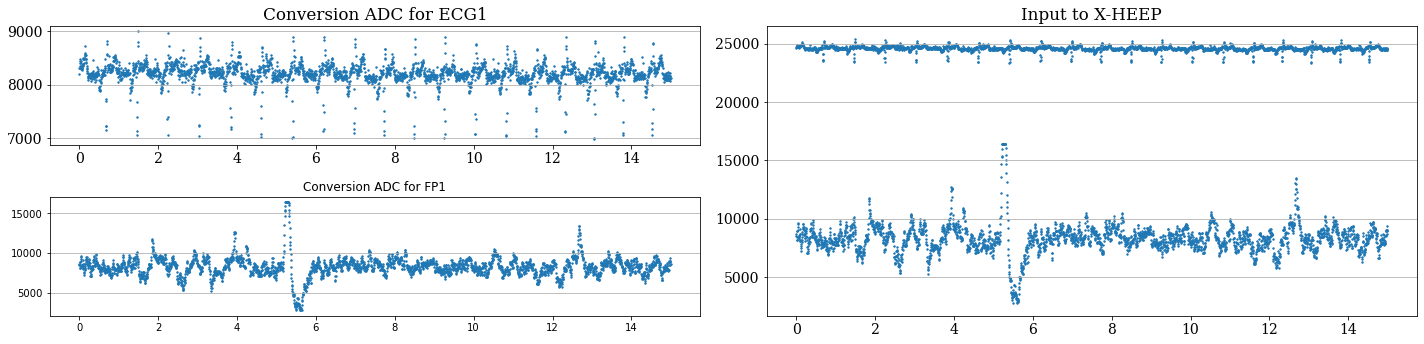

In [6]:
processes = []
# Plot of each channel and the sum of them all.
# This will be used to visualize the input signal after the ADC-emu and the input to the vADC.
def add_to_plot(series, row, col, channel_count, alpha=1):
    ax = plt.subplot2grid((channel_count, 2), (row, col), rowspan = 1 if col == 0 else channel_count )
    ax.set_title(series.name)
    ax.scatter(series.time, series.data, alpha = alpha, s=2  )
    processes.append(series)
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.size"] = 14
    plt.subplots_adjust(hspace=2)
    plt.grid(axis='y', which='both')


fig = plt.figure(figsize=(20,5))

indexes = [titles.index(element) for element in channels_to_plot]
channel_count = len(indexes)

adc_channels = []
for ch_idx, ch_count in zip(indexes, range(len(indexes))):
    adc_channels.append( ADC(   name        = f"ADC for {titles[ch_idx]}",
                                units       = "uV",
                                f_sample_Hz = f_Hz,
                                ampl_bits   = ADC_RESOLUTION_BITS,
                                dynRange    = [-1500, 1500],
                                series      =  Timeseries(  f"{titles[ch_idx]}",
                                                            channels[ch_idx],
                                                            length_s = length_s
                                                        )
                            )
                        )
    add_to_plot(adc_channels[ch_count].conversion, channel_count - ch_count -1, 0, channel_count)

'''````````````````````````````````````
GENERATE THE MULTICHANNEL ADC
````````````````````````````````````'''
mcadc = mcADC("MultiChannel ADC", adc_channels[:channel_count] )
mcadc.TDM()
add_to_plot(mcadc.conversion, 0, 1, channel_count )

# Export the binary file to the application folder
from copy import deepcopy as cp
ADC_BIN_NAME = 'adc_in'
data_file_name = APP_PATH + ADC_BIN_NAME + ".bin"

din = cp(mcadc.conversion)
din.export_bin(path=APP_PATH, name=ADC_BIN_NAME, bytes = ADC_WORD_SIZE_BYTES, bigendian=False)

VADC_ACQUISITION_SAMPLES = len(din.data)
print(f"Set {VADC_ACQUISITION_SAMPLES} words as input")

'''````````````````````````````````````
GENERAL PLOT SETTINGS
````````````````````````````````````'''
plt.title("Input to X-HEEP")
plt.tight_layout()
plt.show()

## Set the different operation parameters

## Share information with the C code

A `definitions.h` file is created to share data between this notebook and the C code. You can add any kind of `#define` (including macros) to the code. 
In this case it is used to share strings that will be used by the software to parse a result and print it so we can extract it from the UART to plot it.  
We also share vADC sampling information to be used in configuring the acquisition.

In [7]:
# Enable the printfs inside X-HEEP application.
# This is not the same as VERBOSE, as
#   a) it actually reflects in C-code and therefore in performance.
#   b) Will not allow to read the output to plot in this notebook
ENABLE_PRINTF       = 1

# Define some standards to parse the X-HEEP output
OUTPUT_START_SEQ    = "# "
OUTPUT_DIVIDER      = "|"
OUTPUT_END_SEQ      = "#---"

# Write the definitions header file to share information with the C code
defs = Definitions( APP_PATH + 'definitions.h', "DEFINITIONS" )
defs.add( "VADC_ACQUISITION_SAMPLES",          VADC_ACQUISITION_SAMPLES )
defs.add( "X_HEEP_SAMPLING_BUFFER_SAMPLES",    X_HEEP_SAMPLING_BUFFER_SAMPLES )
defs.add( "WORD_SIZE_BYTES",                   ADC_WORD_SIZE_BYTES )
defs.add( "WORD_SIZE_BITS",                    ADC_WORD_SIZE_BITS )
defs.add( "ADC_CH_DATA_MASK",                  ADC_CH_DATA_MASK )
defs.add( "VADC_SAMPLING_FREQ_HZ",             int(FREQ_VADC_EMULATED_HZ) )
defs.add( "ENABLE_PRINTF",                     ENABLE_PRINTF)
defs.add( "OUTPUT_START_SEQ",                  OUTPUT_START_SEQ)
defs.add( "OUTPUT_DIVIDER",                    OUTPUT_DIVIDER)
defs.add( "OUTPUT_END_SEQ",                    OUTPUT_END_SEQ)
defs.close()

Then the bitstream of X-HEEP + the necessary peripherals to interact with the FEMU (`x_heep.bit`) is loaded. It should be located in `~/x-heep-femu-sdk/hw/` (w.r.t. this notebook: `../../../../hw/`). 

In [8]:
xh = x_heep()

✅ Bitstream loaded


## Compile the code and run the application

The C code written for X-HEEP in `~/x-heep-femu-sdk/sw/riscv/apps/adc-emu/adc-emu.c` will be compiled to generate the `code.*` files in `~/x-heep-femu-sdk/sw/build/`. This will be later loaded into X-HEEP for it to execute. 

After compilation, the `virtual ADC` is initialized with the signal that will be fed.

Before running the program performance counters are reset and started. These will capture the execution of X-HEEP and will be used to asses the latency of the execution and average power of each block of X-HEEP. 

During the exeuction the UART output will be printed live. 

* You can change the variable `SKIP_COMPILE`  to 1 to avoid compiling each time.
* You can change the variable `VERBOSE`       to 0 to supress the live printing of the UART.

> The execution of this cells takes around 9 seconds (until compilation) + around 6 seconds for the program to start.

In [9]:
# Skip compiling if all you want to do is run the application
# Note that the compilation is affected by the parameters written to the definitions.h file
if 1: print("⏩ Skipped compilation")
else: xh.compile_app("vadc_example")

vadc    = vADC(data_file_name)
perfc   = PerfCounters()

xh.run_app(verbose = False, perfCounters = perfc);

⏩ Skipped compilation
✅ Return SUCCESS
 


### Parse the UART output

Until now most steps were significantly _"application-agnostic"_. The parsing of the output will strongly depend on what you are trying to extract from X-HEEP.

In [10]:
# Extract the UART output from X-HEEP
app_out = xh.uart_data

# Find positions of strings starting with "#"
starts = [i for i, s in enumerate(app_out) if s.startswith(OUTPUT_START_SEQ)]
# Find positions of strings starting with "#"
ends = [i for i, s in enumerate(app_out) if s.startswith(OUTPUT_END_SEQ)]

# Sanity check to make sure that all output lists are closed
if len(starts) != len(ends): sys.exit("❌ Invalid output")

# Will divide the outputs in a list of dictionaries containing headers and data
outs = []
for seq in range(len(starts)):
    s = starts[seq]
    e = ends[seq]
    # Strip the headers of the format markers
    headers = app_out[s].split(OUTPUT_DIVIDER)
    headers = [ h.strip().replace(OUTPUT_START_SEQ,'') for h in headers ]
    # Strip the data of the format markers and covert it into a numpy array of integers
    data  = [line.split(OUTPUT_DIVIDER) for line in app_out[s+1:e]]
    data = np.asarray([ [int(i.strip()) for i in d] for d in data ]).T
    # Add the result to the list of dictionaries
    outs.append( {'headers':headers, 'data':data } )

# Convert all outputs to timeseries
# Each timeseries will be part of a sequence: a group of timeseries of the same length (were printed as different columns of a same process)
# All timeseries of a same sequence share timescale (that could be none)
raw_series = []
for seq in outs:
    seqs = []
    cols_i = 0
    cols_f = len(seq['headers'])
    time = []
    # If some first column of a sequence is a timestamp array, use it as time of all sequences
    if "time" in seq['headers'][0].lower():
        time = seq['data'][0]
        cols_i = 1
    # For the rest of the sequences just use the data as data
    for c in range(cols_i, cols_f):
        s = Timeseries( seq['headers'][c] )
        s.data = seq['data'][c]
        s.time = time
        seqs.append(s)
    raw_series.append(seqs)

# Access the information as `raw_series[0][1].name` (the name of the second column of the first sequence)
print("Output included", len(raw_series), "sequences")
for s in range(len(raw_series)):
    print(f">>> Sequence {s} has headers: {[ h.name for h in raw_series[s] ]}")

Output included 1 sequences
>>> Sequence 0 has headers: ['Output']


## Plot the input and output

The obtained output will be plotted along with the input data `din`. 

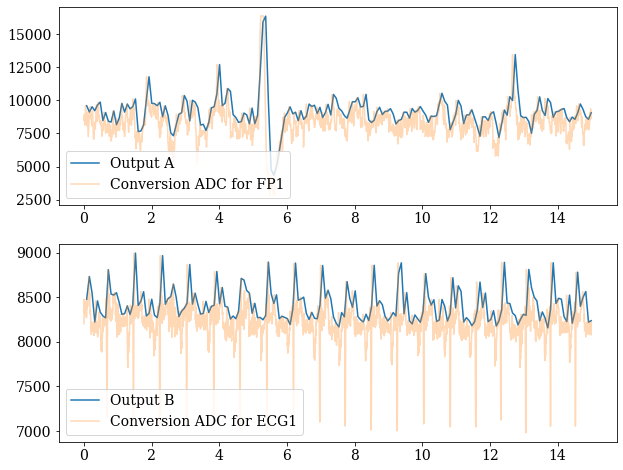

In [11]:
import matplotlib.pyplot as plt

# make a deep copy to ensure that changes to the list will not affect the one obtained from the output
import copy
series = copy.deepcopy(raw_series)

step = max(din.time)/int(VADC_ACQUISITION_SAMPLES/X_HEEP_SAMPLING_BUFFER_SAMPLES)
time = list(np.arange(step, max(din.time) + step, step))

data_a = []
data_b = []
for d in series[0][0].data:
    data_a.append(d & 0x00003FFF)
    data_b.append((d & 0x3FFF0000) >> 16)


series = []
series.append(Timeseries("Output A", data = data_a, time = time))
series.append(mcadc.channels[0].conversion)
series.append(Timeseries("Output B", data = data_b, time = time))
series.append(mcadc.channels[1].conversion)

fig = plt.figure(figsize=(10,8))
plt.title("Output from X-HEEP")

ax = plt.subplot(2,1,1)
ax.plot(series[0].time, series[0].data)
ax.plot(series[1].time, series[1].data, alpha=0.3)
plt.legend([ s.name for s in series[:2] ], loc='lower left')

ax = plt.subplot(2,1,2)
ax.plot(series[2].time, series[2].data)
ax.plot(series[3].time, series[3].data, alpha=0.3)
plt.legend([ s.name for s in series[2:] ], loc='lower left')

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 14


## Performance and Energy

During the execution of the application performance measurements were generated. In this section we will read them to generate latency and energy estimations. 

The report generated is stored in `~/x-heep-femu-sdk/sw/riscv/build/energy_estim.csv`.

Latency, power and energy results will be computed and can be compared to some defined budgets. 

You can prune your design by removing modules to estimate the power consumption of X-HEEP without these blocks. 

---------------------
  Full System  
Total cycles: 	92.25 ms
Total energy: 	68.08 µJ
Avg power:	737.99 µW
---------------------
  System Pruning  
Latency:	92.25 ms
Energy: 	24.18 µJ
Avg Pwr:	262.09 µW
✅ Latency SUCCESS
✅ Power SUCCESS


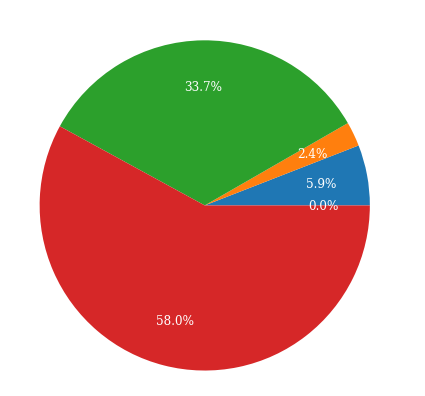

In [17]:
from copy import deepcopy as cp
import pprint
from report import *

# Define some budgets that we should not cross
POWER_BUDGET_W      = 300e-6
LATENCY_BUDGET_S    = 1

perfc.read_perf_cnt();         # Read the performance counters
perfc.estimate_performance(verbose=False);     # Estimate the performance
perfc.estimate_energy("HVT", verbose=False);   # Estimate the energy using the HVT model

print("---------------------")
print("  Full System  ")
rep_summary, rep_latency, rep_energy  = report() # Get the report

print("---------------------")
print("  System Pruning  ")


# Remove modules that will not be used in the design.
# In case you want to print the dictionaries containing the breakdown
if 0: pprint.pprint(rep_energy)
# Otherwise you can check the names in sdk/sw/riscv/build/energy_estim.csv
pruned_energy = cp(rep_energy)
pruned_energy = remove_module(pruned_energy, "debug ao" )
pruned_energy = remove_module(pruned_energy, "uart ao" )
pruned_energy = remove_module(pruned_energy, "spi ao" )
pruned_energy = remove_module(pruned_energy, "spi flash ao" )
pruned_energy = remove_module(pruned_energy, "gpio" )
pruned_energy = remove_module(pruned_energy, "i2c" )
pruned_energy = remove_module(pruned_energy, "timer" )

rep_summary['Energy_J'] = pruned_energy['Total']
rep_summary['Power_W']  = rep_summary['Energy_J']/rep_summary['Latency_s']

print(f"Latency:\t{rep_summary['Latency_s']*1e3:0.2f} ms")
print(f"Energy: \t{rep_summary['Energy_J']*1e6:0.2f} µJ")
print(f"Avg Pwr:\t{rep_summary['Power_W']*1e6:0.2f} µW")

print( "✅ Latency SUCCESS" if rep_summary['Latency_s'] < LATENCY_BUDGET_S  else "❌ Latency FAIL" )
print( "✅ Power SUCCESS"   if rep_summary['Power_W']   < POWER_BUDGET_W    else "❌ Power FAIL"   )

# @ToDo: Change to a bar graph (where the objectives can also be plotted)
# Plot a breakdown of the energy consumption
plot_energy( pruned_energy, level=1 )